In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy.constants as co
import scipy.stats as ss
import itertools
import pickle
from scipy import signal

In [2]:
# constants

# time for fast neutron to scatter enough times to fall to thermal energies
t_slow = 2.7e-6 # sec (2.7 us)

# time for thermal neutron to capture or decay (or otherwise be removed from consideration)
t_stop = 1e-5 # sec (100 us)

# approx room temperature
T = 298 # K (25 C)

# physical constants
k = co.physical_constants['Boltzmann constant in eV/K'][0] # Boltzmann constant in eV/K
B = 1/k/T # thermal energy constant [1/eV]
m_n = co.physical_constants['neutron mass energy equivalent in MeV'][0]*1e6 # neutron mass in eV
yr = 365*24*3600 # seconds per year
sealevel = 4/3600 # accepted neutron flux at sea level [cm^-2 s^-1]

In [3]:
# functions

def integrate_df(df):
    # (left-sided rectangular integral)
    dE = -df['E'].diff(periods = -1)
    dE.iat[-1] = dE.iat[-2]
    A = df['spec']*dE
    return A.sum()

def maxwell(E, B):
    # height of Maxwell distribution for energy E (eV) and temperature T (K) related to B via B = 1/kT
    return 2*B*np.sqrt(B*E/np.pi)*np.exp(-B*E)

In [4]:
# read in fast neutron flux spectrum (from reading_n_spectra.ipynb)
fast_flux_df = pd.read_pickle('data/FDF.txt') # 'E' in MeV, 'spec' in neutrons cm^-2 sec^-1 MeV^-1


#use numpy arrays
ff = np.asarray(fast_flux_df['E']);
ffspec = np.asarray(fast_flux_df['spec']);

In [5]:
#smooth the data
ffspec_smooth = signal.savgol_filter(ffspec, 501, 3) # window size 501, polynomial order 3

In [6]:
Es = np.geomspace(0.0001, 1e4, 2000)
Max = maxwell(Es, B)
snothermal = 4144.9/10000/86400
Therms = snothermal*Max

In [7]:
cutoff=0.3

ffhe = ff[ff>cutoff]
ffhespec = ffspec[ff>cutoff]

#smooth the data
ffhespec_smooth = signal.savgol_filter(ffhespec, 2001, 3) # window size 1001, polynomial order 3

ffle = ff[ff<=cutoff]
fflespec = ffspec[ff<=cutoff]
print(np.size(ffle))

#smooth the data
fflespec_smooth = signal.savgol_filter(fflespec, 75, 3) # window size 1001, polynomial order 3

175


In [8]:
# extrapolate line from lower-energy fast neutrons
E_thresh = 2e-2 # upper bound of linear region
E_therm = 0.15e-6 # near boundary of where thermal distribution has peak

fast_lin_df = ffle[ffle < E_thresh]
fast_lin_df_spec = fflespec_smooth[ffle< E_thresh]

In [9]:
fitted_line = ss.linregress(np.log(fast_lin_df), np.log(fast_lin_df_spec))
print(fitted_line)

LinregressResult(slope=-0.34198906017017205, intercept=-12.883178144228607, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.014824519476613129, intercept_stderr=0.06273875262265781)


In [10]:
def fast_extrapolation_line(E):
    # return height of fitted loglog line, if energy is larger than thermal threshold
    return np.exp(fitted_line.intercept + fitted_line.slope*np.log(E))*(E > E_therm)

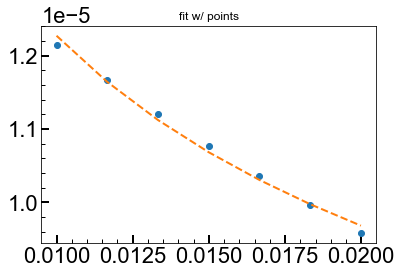

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('fit w/ points')
ax.plot(fast_lin_df, fast_lin_df_spec, 'o')
ax.plot(fast_lin_df, fast_extrapolation_line(fast_lin_df), linestyle = 'dashed')

In [12]:
Etherm = Es/1e6

print(np.size(Etherm),np.size(ffle),np.size(ffhe))
print(np.shape(Etherm))

2000 175 5825
(2000,)


In [13]:
etot = np.concatenate((Etherm,ffle,ffhe))
etot = np.unique(etot)
etotspec = np.zeros((np.size(etot),),dtype=np.float64)
print(np.size(etot),np.size(etotspec))

7999 7999


In [14]:
Therms_new = snothermal*Max + fast_extrapolation_line(Es/1e6)/1e6

In [15]:
etotspec[etot<=Etherm[-1]] = Therms_new*1e6
etotspec[(etot>Etherm[-1])&(etot<ffle[-5])] = fflespec_smooth[1:-5]
etotspec[(etot>ffle[-1])] = ffhespec_smooth
dee = etotspec>1.0e-9
etot = etot[dee]
etotspec = etotspec[dee]

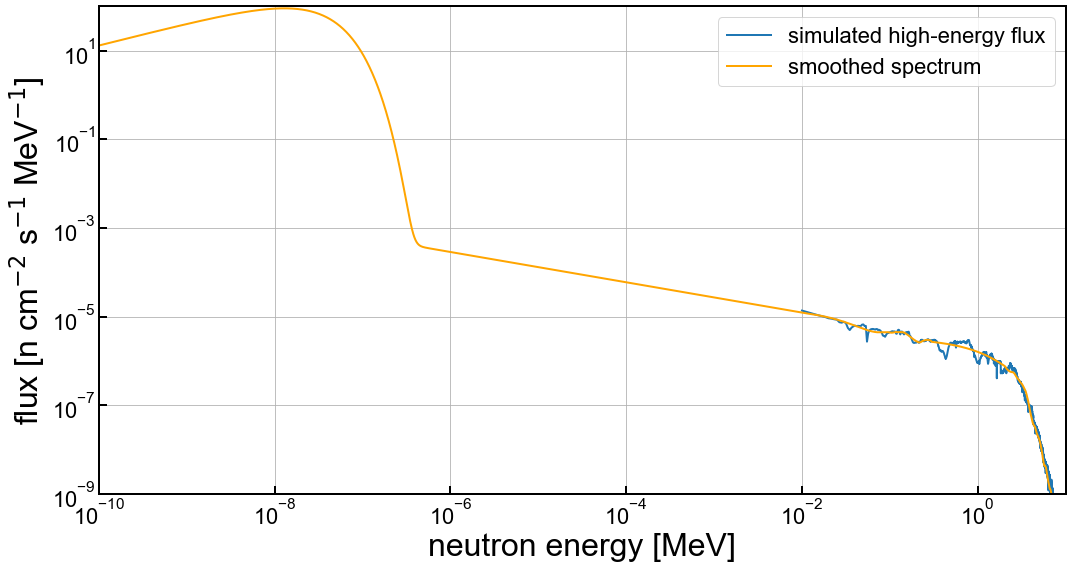

In [16]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(ff, ffspec,label='simulated high-energy flux')
ax1.plot(etot, etotspec,color='orange',label="smoothed spectrum")



ymin = 1e-9
ymax = 100.0

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('flux [n cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [17]:
#get some cross section data
import ENDF6
f = open('data/jendl5_3He.endf6')
lines = f.readlines()
sec = ENDF6.find_section(lines, MF=3, MT=2)  # Elastic
x, y = ENDF6.read_table(sec)

sec_np = ENDF6.find_section(lines, MF=3, MT=103)  # Elastic
xnp, ynp = ENDF6.read_table(sec_np)

In [18]:
#densities to convert to macroscopic xn
rholhe3 = 0.0792 #g/cm^3
masshe3 = 3.016 #molar mass
nhe3 = (rholhe3/masshe3)*co.N_A

In [19]:
ESigElMeV = x/1e6
SigElMeV = y*1e-24*nhe3

ESigMeV = xnp/1e6
SigMeV = ynp*1e-24*nhe3

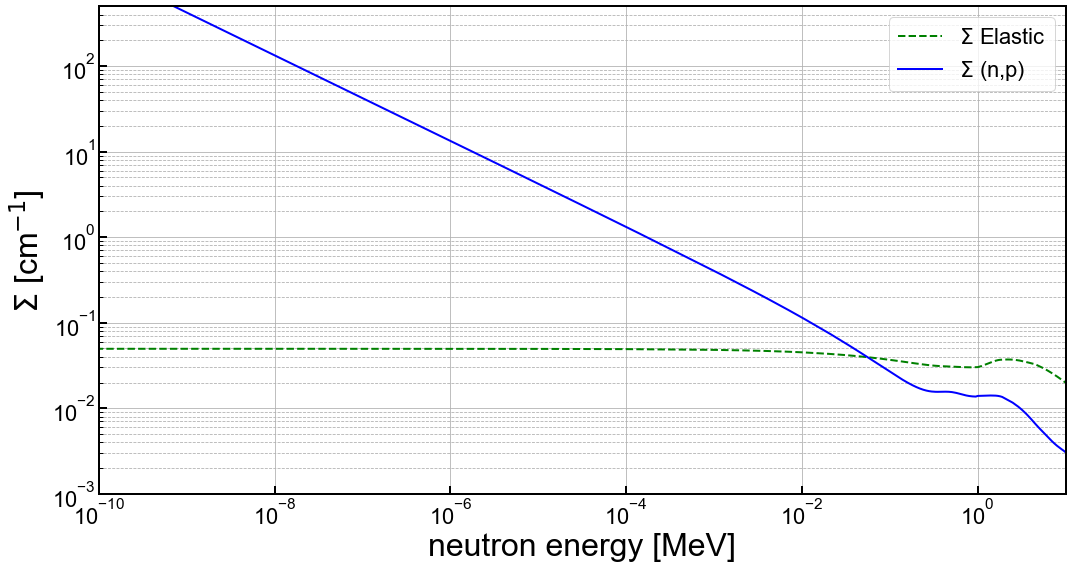

In [20]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(ESigElMeV, SigElMeV,color='g',linestyle='--',label="$\Sigma$ Elastic")
ax1.plot(ESigMeV, SigMeV,color='b',label="$\Sigma$ (n,p)")



ymin = 1e-3
ymax = 5e2

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('$\Sigma$ [cm$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [21]:
import scipy.interpolate as inter

flux = inter.InterpolatedUnivariateSpline(etot, etotspec , k=3)
sigma = inter.InterpolatedUnivariateSpline(ESigElMeV, SigElMeV , k=3)

In [22]:
print(flux(1.0e-3))
print(sigma(1.0e-3))

2.6969568815610176e-05
0.04814921976724744


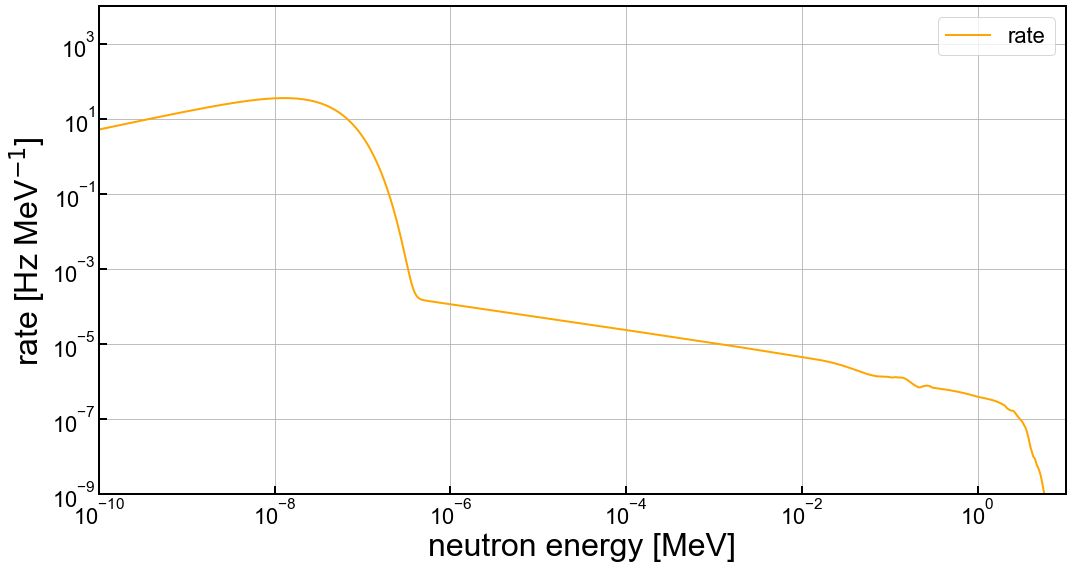

In [23]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(15.0,8.0),sharex=True)
ax1 = axes


#print(estring)
ax1.plot(etot, flux(etot)*sigma(etot)*8,color='orange',label="rate")



ymin = 1e-9
ymax = 1e4

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

plt.loglog()
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(1e-10, 10) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'neutron energy [MeV]')
ax1.set_ylabel('rate [Hz MeV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()

In [24]:
elrt = pd.DataFrame()
erange = (etot>0.764)
elrt['E']=etot[erange]
elrt['spec']=flux(etot[erange])*sigma(etot[erange])*8
print(integrate_df(elrt))

6.348181241377308e-07


In [25]:
print(f'SNOLAB counts above 764 keV in 1 yr = {integrate_df(elrt)*60*60*24*365:1.2f} n')

SNOLAB counts above 764 keV in 1 yr = 20.02 n


In [26]:
elrt = pd.DataFrame()
erange = (etot>0.0)
elrt['E']=etot[erange]
elrt['spec']=flux(etot[erange])*sigma(etot[erange])*8
print(integrate_df(elrt))

3.2399039580762434e-06


In [27]:
print(f'SNOLAB counts above 0 keV in 1 yr = {integrate_df(elrt)*60*60*24*365:1.2f} n')

SNOLAB counts above 0 keV in 1 yr = 102.17 n


Kinematics
----------

In [28]:
#helion mass energy equivalent in MeV
mn = co.physical_constants['neutron mass energy equivalent in MeV'][0]
m3 = co.physical_constants['helion mass energy equivalent in MeV'][0]

In [29]:
# local functions (response & interpolation)
from model_util.response import response_function, solve_response, A_cols
from model_util.interpolate import interpolate
from model_util.loading import load_parameters, load_specific_row

In [30]:


# load the data
data, energy = load_parameters(f"data/3He-3-shaping-time.csv")
error, error_energy = load_parameters(f"data/3He-3-error.csv")

# these columns should be the same
assert energy == error_energy



In [31]:
# shared variable declarations
Emin: float = 150
Emax: float = 2500

stepsize: int = 10000

instrument_stepping_time = 3

#neutron_energy: float = float(input("Enter the desired energy in keV: "))
neutron_energy = 1500
print(f"Using neutron energy = {neutron_energy} keV")

Using neutron energy = 1500 keV


In [32]:
parameters_interpolated = interpolate(
    input_energy = neutron_energy,
    energy = energy,
    step_time = data,
)

In [33]:
# for type hints
from typing import Tuple, List
# solve response for interpolated values 
interp_xy_values: Tuple[list, list] = solve_response(
    En = neutron_energy,
    parameters = parameters_interpolated,
    Emin = Emin,
    Emax = Emax,
    step = stepsize,
)

In [34]:
print(parameters_interpolated[11]-5*parameters_interpolated[12]) 
# parameters are two numbers behind after A10--b/c start from zero and A10 doesn't exist

1403.5145100238328


In [35]:
Ermax = (4*mn*m3/(mn+m3)**2)*neutron_energy
print(Ermax)

1127.0592195060374


In [36]:
a = solve_response(
    En = neutron_energy,
    parameters = parameters_interpolated,
    Emin = Emin,
    Emax = Emin,
    step = 1,
)
print(a[1])

[4.900093796775708]


In [37]:
def gas_response(Er,E):
    fdata, fenergy = load_parameters(f"data/3He-3-shaping-time.csv")
    fparameters_interpolated = interpolate(
      input_energy = E,
      energy = fenergy,
      step_time = fdata,
    )
    #turn n,p off
    fparameters_interpolated[0]=0.0
    fparameters_interpolated[7]=0.0
    #proton escape off.
    fparameters_interpolated[3]=0.0
    fparameters_interpolated[5]=0.0
    #turn argon peak off
    fparameters_interpolated[13]=10.0
    fparameters_interpolated[14]=0.0
    fparameters_interpolated[15]=0.0
    fparameters_interpolated[16]=0.0
    return solve_response(En = E,parameters = fparameters_interpolated,Emin = Er,Emax = Er,step = 1)[1][0]
    
    
    

In [38]:
print(gas_response(120,1500))

2.618346174378149


In [39]:
def jointErEn(Er,E):
    return (gas_response(Er,E)*flux(E/1000)*sigma(E/1000)*8/integrate_df(elrt))

In [40]:
print(jointErEn(120,1500))

0.2508145791743223


In [41]:
v_gas = np.vectorize(lambda Er: gas_response(Er,1500))
print(v_gas([150.0,120.0]))

[2.57957672 2.61834617]


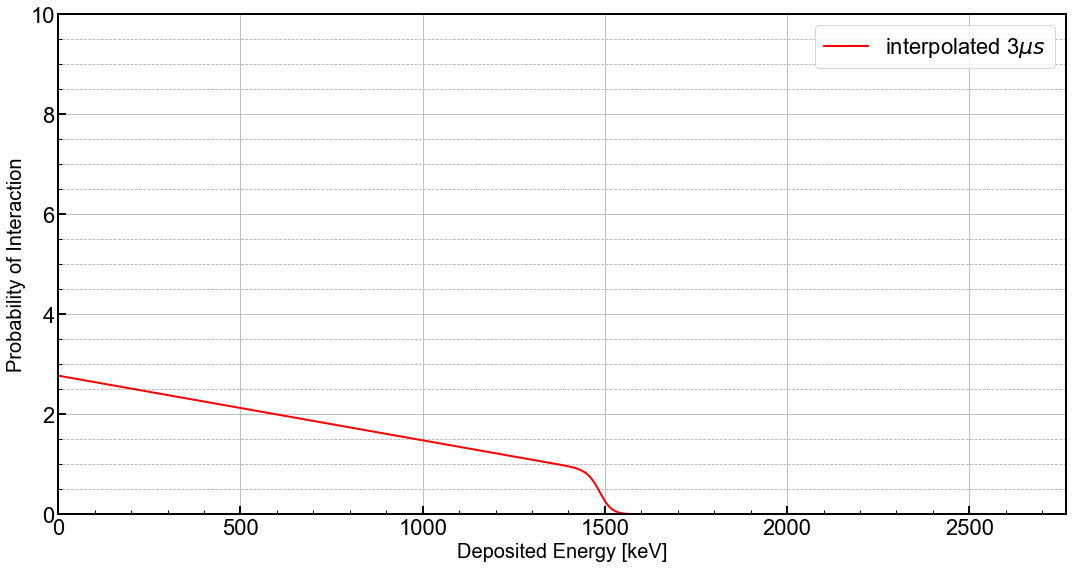

In [42]:


Ers = np.linspace(0.0,2000.0+764,1000)



Ymin = 0
Ymax = 10

# set up plot
fig, ax = plt.subplots(1,1,figsize=(15,8))
# label and style things
ax.set_xlim(0, 2000+764) 
ax.set_ylim(Ymin, Ymax)
ax.set_xlabel(r'Deposited Energy [keV]', fontsize=20)
ax.set_ylabel('Probability of Interaction', fontsize=20)
#ax.set_title(f'{neutron_energy}keV Neutron Response with {instrument_stepping_time}$\mu$s Stepping Time', fontsize=20)
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# plot values
ax.plot(Ers, v_gas(Ers), color = "red", label = f"interpolated {instrument_stepping_time}$\mu s$")

# save and plot the figure
plt.legend()
plt.tight_layout()
#fig.savefig(f'figures/interpolated_{neutron_energy}keV_{instrument_stepping_time}us.png')
plt.show()



In [43]:
v_el = np.vectorize(lambda Er,E: jointErEn(Er,E))
print(v_el(150.0,[1500,1515]))
n = np.size(etot)
etot_trim = etot[0:np.size(etot):10]*1000
print(np.shape(etot_trim))
erange = (etot_trim>0.0)
eldis = pd.DataFrame()
eldis['spec']=v_el(150.0,etot_trim[erange])


def ElasticEr(Er):
    eldis = pd.DataFrame()
    erange = (etot_trim>0.0)
    eldis['E']=etot_trim[erange]
    eldis['spec']=v_el(Er,etot_trim[erange])
    return integrate_df(eldis)

[0.24710081 0.24348961]
(613,)


In [44]:
test_parameters_interpolated = interpolate(
    input_energy = 100.0,
    energy = energy,
    step_time = data,
)
print(test_parameters_interpolated[11])
print(test_parameters_interpolated[12])
#print(np.exp((742.0-test_parameters_interpolated[11])/test_parameters_interpolated[12]))

0.0
1.0


In [62]:
print(ElasticEr(764.0))
print(etot_trim[-1])
print(ElasticEr(etot_trim[-200]))
print(etot_trim[-200])

338.9279869851102
6879.79
0.029518353570379987
3566.44


In [46]:
vElasticEr =np.vectorize(ElasticEr)
elnorm = pd.DataFrame()
erange = (etot_trim>0.0)
elnorm['E']=etot_trim[erange]
elnorm['spec']=vElasticEr(etot_trim[erange])
print(integrate_df(elnorm))
print(np.shape(elnorm['spec']))

1017889.0363071562
(613,)


In [47]:
print(np.shape(etot_trim[erange]))
#print(np.shape(vElasticEr(etot_trim[erange])))
Er_distribution = inter.InterpolatedUnivariateSpline(etot_trim[erange], elnorm['spec']/integrate_df(elnorm) , k=3)

(613,)


In [48]:
print(Er_distribution(502.84))
ecut = (etot_trim>496.0) & (etot_trim<506.0)
print(np.shape(etot_trim[ecut]))
print(etot_trim[ecut])
print(vElasticEr(etot_trim[ecut])/integrate_df(elnorm))

0.0005994541409887157
(1,)
[502.84]
[0.00059945]


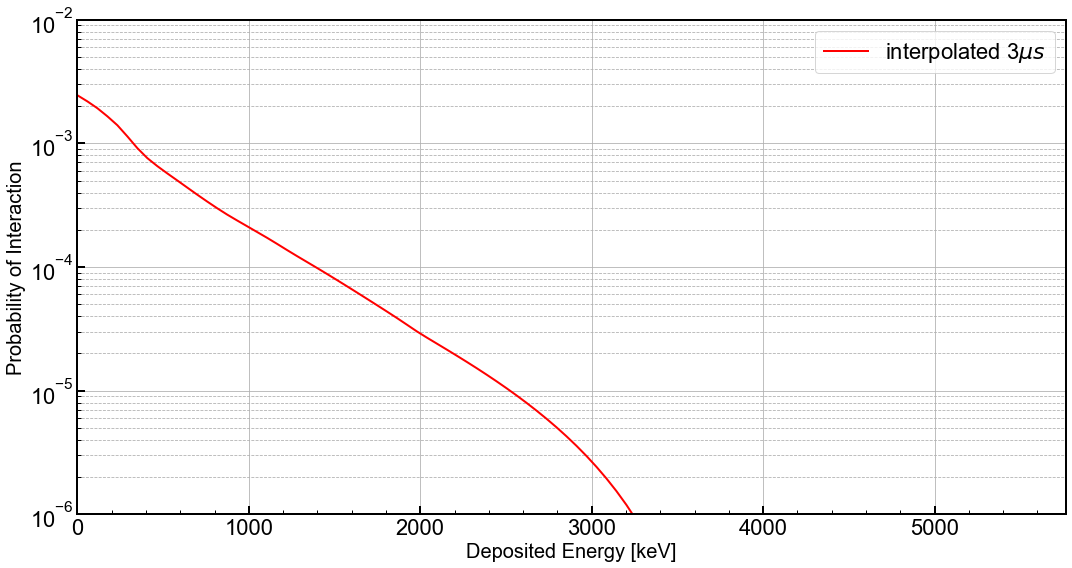

In [49]:
#vElasticEr =np.vectorize(ElasticEr)
Ers = np.linspace(0.0,5000.0+764,100)
Ymin = 1e-6
Ymax = 1e-2

# set up plot
fig, ax = plt.subplots(1,1,figsize=(15,8))
# label and style things
ax.set_yscale('log')
ax.set_xlim(0, 5000+764) 
ax.set_ylim(Ymin, Ymax)
ax.set_xlabel(r'Deposited Energy [keV]', fontsize=20)
ax.set_ylabel('Probability of Interaction', fontsize=20)
#ax.set_title(f'{neutron_energy}keV Neutron Response with {instrument_stepping_time}$\mu$s Stepping Time', fontsize=20)
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# plot values
#ax.plot(Ers, vElasticEr(Ers), color = "red", label = f"interpolated {instrument_stepping_time}$\mu s$")
ax.plot(Ers, Er_distribution(Ers), color = "red", label = f"interpolated {instrument_stepping_time}$\mu s$")

# save and plot the figure
plt.legend()
plt.tight_layout()
#fig.savefig(f'figures/interpolated_{neutron_energy}keV_{instrument_stepping_time}us.png')
plt.show()

In [50]:
print(np.shape(Ers))

(100,)


Final Distribution
------------------

In [93]:
Enf = etot*1000
PDFnf = Er_distribution(etot*1000)/0.9816871 

In [94]:
neutpdf = pd.DataFrame()
neutpdf['E']=Enf
neutpdf['spec']=PDFnf
print(f'Elastic Normalization = {integrate_df(neutpdf):1.7f} ')

Elastic Normalization = 1.0000000 


In [95]:
def cdf(df,E):
    cdf_spec = pd.DataFrame()
    cdf_spec['E']=Enf[Enf<=E]
    cdf_spec['spec']=PDFnf[Enf<=E]
    return integrate_df(cdf_spec)

In [102]:
print(cdf(neutpdf,3100))

0.9998439195908563


In [118]:
import scipy.optimize as so
def invcdf(df,p):
    f = lambda a: cdf(df,a)-p
    #print(f(0.9938433965248))
    return so.brentq(f,1e-6,10000,rtol=0.0001,maxiter=100)

In [122]:
print(invcdf(neutpdf,0.99))

2106.271457918572


In [123]:
Ncounts = np.int32(integrate_df(elrt)*60*60*24*365)
print(Ncounts)

102


In [125]:
invcdf_l = lambda r: invcdf(neutpdf,r)

invcdf_l_vec = np.vectorize(invcdf_l)

In [ ]:
#turn on and off--this takes a long time (few hours)
import h5py
from tqdm.auto import tqdm

if True:
  #try 100x the amount of counts
  r = np.random.uniform(0.006,1.0,size=Ncounts*100)
  #r = r[r>0.006] #this is the point where it starts to fail. 
  print(np.shape(r))

  #egen = invcdf_l_vec(r)
  egen = np.zeros(np.shape(r))
  for i,rand in enumerate(tqdm(r)):
    egen[i] = invcdf_l(rand)

  #save the results for the MS fit
  path='{}/{}/'.format('SNOLAB','elastic')

  filename = 'data/SNOLAB_sims.h5'

  #remove vars
  f = h5py.File(filename,'a')
  En = path+'En' in f


  if En:
    del f[path+'En']


  dset = f.create_dataset(path+'En',np.shape(egen),dtype=np.dtype('float64').type)
  dset[...] = egen


  f.close()

(10200,)


  0%|          | 0/10200 [00:00<?, ?it/s]